<a href="https://colab.research.google.com/github/danilovabg/SkillFactory/blob/master/project3_Danilova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.2 MB/s eta 0:00:00


In [25]:
import pandas as pd
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import zipfile
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!unzip /content/drive/MyDrive/sf-booking.zip

Archive:  /content/drive/MyDrive/sf-booking.zip
  inflating: hotels_test.csv         
  inflating: hotels_train.csv        
  inflating: submission.csv          


In [216]:
zf = zipfile.ZipFile('/content/drive/MyDrive/sf-booking.zip')
test = pd.read_csv(zf.open('hotels_test.csv'))
train = pd.read_csv(zf.open('hotels_train.csv'))
sub = pd.read_csv(zf.open('submission.csv'))

<ipython-input-119-6c8a7e78a861>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f")


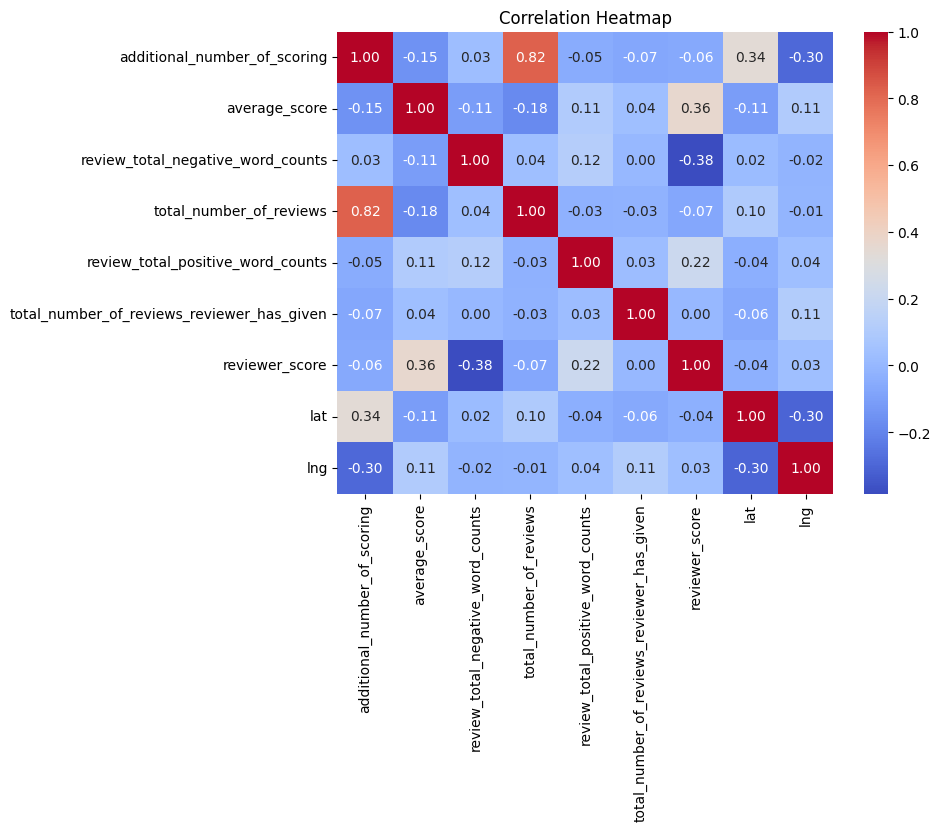

In [119]:
plt.figure(figsize=(8, 6))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show();

Колонки total_number_of_rewiews и additional_number_of_scoring мультиколинеарны, по этому одну из них стоит удалить

total_number_of_rewiews коррелирует с rewiewer_scor с коеффициентом 0,07

additional_number_of_scoring коррелирует с rewiewer_scor с коеффициентом 0,06
(в целом обе колонки безполезны, но удалю только одну)
по этому удалю additional_number_of_scoring

total_number_of_reviews_rewiewer_has_given коеффициент корреляции равен 0, после дальнейших преобразований удалю эту колонку тоже

еще два кандидата на удаление - lng, lat

In [217]:
# Из адреса извлекку данные о стране
# (я так же извлекла город из адреса, но количество стран и городов совпадает, по этому этот фичер не принесет дополнительно ничего в модель
#  то есть в данном датасете для каждой страны представлены отели только из одного города)
# я убрала код для извлечения города, чтобы не засорять ноутбук
train['country'] = train['hotel_address'].apply(lambda x: ' '.join(x.split()[-2:]) if x.split()[-1] == 'Kingdom' else x.split()[-1])
# так же извлеку данные из даты отзыва
train['month'] = train['review_date'].apply(lambda x: int(x.split('/')[0]))
train['year'] = train['review_date'].apply(lambda x: x.split('/')[-1])
train = train.drop('additional_number_of_scoring', axis = 1)
# train = train.drop('lat', axis = 1)
# train = train.drop('lng', axis = 1)

test['country'] = test['hotel_address'].apply(lambda x: ' '.join(x.split()[-2:]) if x.split()[-1] == 'Kingdom' else x.split()[-1])
test['month'] = test['review_date'].apply(lambda x: int(x.split('/')[0]))
test['year'] = test['review_date'].apply(lambda x: x.split('/')[-1])
test = test.drop('additional_number_of_scoring', axis = 1)
# test = test.drop('lat', axis = 1)
# test = test.drop('lng', axis = 1)

In [218]:
# Из названия отеля мне не удалось извлечь какой-либо полезной информации
# В колонке национальность слишком много значений,
# по этому я просто сделаю колонку с флагом является ли человек который оставляет отзыв резидентом страны в которой находится отель
train['nationality_flag'] = train.apply(lambda h: 1 if h['country'] in h['reviewer_nationality'] and h['reviewer_nationality'] != ' ' else 0, axis=1)
test['nationality_flag'] = test.apply(lambda h: 1 if h['country'] in h['reviewer_nationality'] and h['reviewer_nationality'] != ' ' else 0, axis=1)

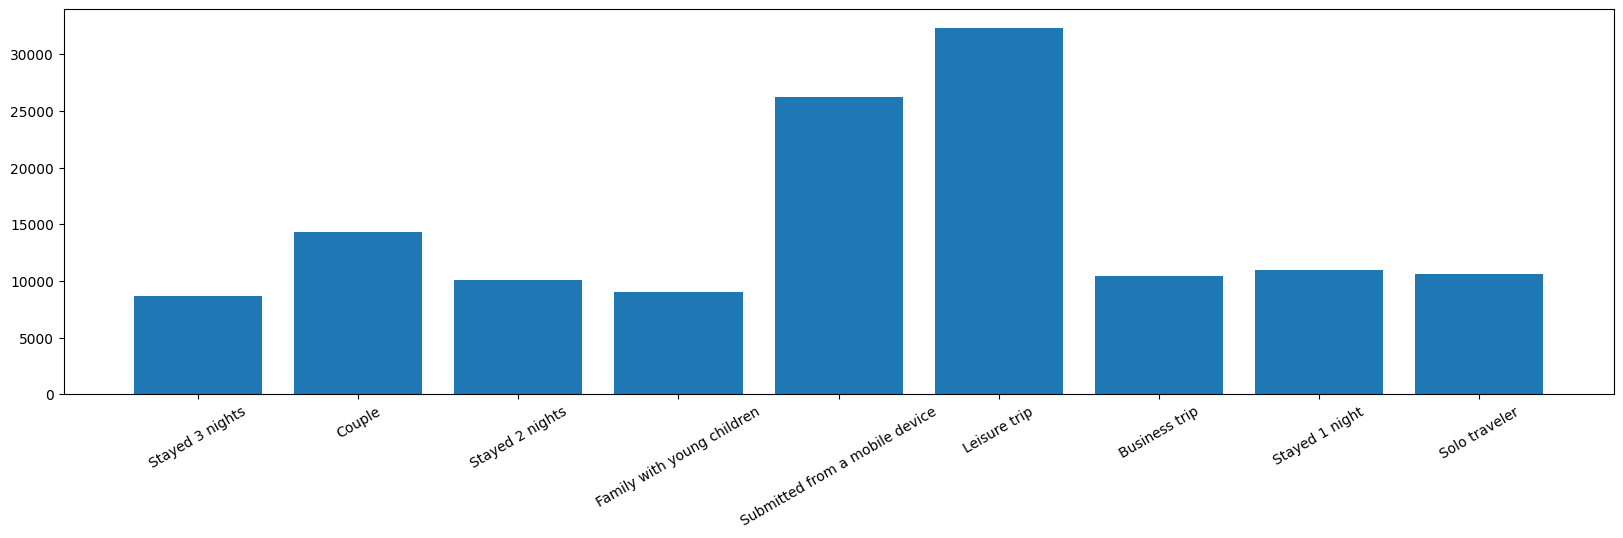

In [219]:
# Тут пытаюсь извлечь информацию из колонки с тагами (думаю этот датасет лучше прочитать пайспарком так как он поддерживает тип данных массив в колонке
# но я не была уверена можно ли так сделать в задании, так как тут мы работаем с пандасом, по этому пришлось криво обрабатывать данные)
# я собираю таги в один лист и делаю словарь (для удобнйо визуализации)
a = [l for el in train['tags'].unique().tolist() for l in el[3:-3].split(" ', ' ")]
tags_dict = {x: a.count(x) for x in list(set(a)) if a.count(x) >= (0.02*len(train))}

plt.figure(figsize = (20, 5))
plt.bar(tags_dict.keys(), tags_dict.values())
plt.xticks(rotation = 30);

In [221]:
# сделаю простой оне-хот енкодинг для тагов которые встречаются в 2 или более % записей
for col in tags_dict.keys():
    if 'night' not in col:
        print(col)
        train[col] = train['tags'].apply(lambda x: 1 if col in x else 0)
        test[col] = test['tags'].apply(lambda x: 1 if col in x else 0)

Couple
Family with young children
Submitted from a mobile device
Leisure trip
Business trip
Solo traveler


In [222]:
# Создам колонку с количеством ночевок (извлекаю из тагов)
def num_nights(x):
     x_tags = [l for l in x[3:-3].split(" ', ' ")]
     for tag in x_tags:
        if 'night' in tag:
            tmp = [int(word) for word in tag.split() if word.isdigit()]
            return tmp[0] if len(tmp) > 0 else 0
     return 0

train['num_of_nights'] = train['tags'].apply(lambda x: num_nights(x))
test['num_of_nights'] = test['tags'].apply(lambda x: num_nights(x))

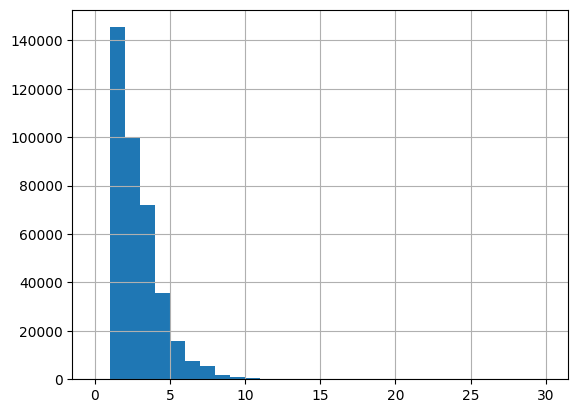

In [210]:
train['num_of_nights'].hist(bins = 30);

In [223]:
# Извлекаю числовой признак из колонки days_since_review
train['days_since_review'] = train['days_since_review'].apply(lambda x: int(x.split()[0]))
test['days_since_review'] = test['days_since_review'].apply(lambda x: int(x.split()[0]))

In [224]:
# Разделяю данные на 3 списка: категориальные, числовые и текст
cat_f = ['country', 'year', 'month', 'num_of_nights']
text = ['negative_review', 'positive_review']

#преобразую данные в тип категориальный тип данных
for el in cat_f:
  train[el] = train[el].astype('category')
  test[el] = test[el].astype('category')

# Собираю числовые колонки в список
num_columns = []
for el in train.columns.tolist():
    if 'float' in str(train[el].dtypes) or 'int' in str(train[el].dtypes):
        num_columns.append(el)


num_columns.remove('reviewer_score')

## Посмотрим на корреляции еще раз

In [225]:
train['lat'] = train['lat'].fillna((train['lat'].mean()))
train['lng'] = train['lng'].fillna((train['lng'].mean()))

test['lat'] = test['lat'].fillna((test['lat'].mean()))
test['lng'] = test['lng'].fillna((test['lng'].mean()))

In [226]:
df_corr = train[num_columns + cat_f + text + ['reviewer_score']]
y = train['reviewer_score'].astype('int')

<ipython-input-227-bab68953c2ea>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")


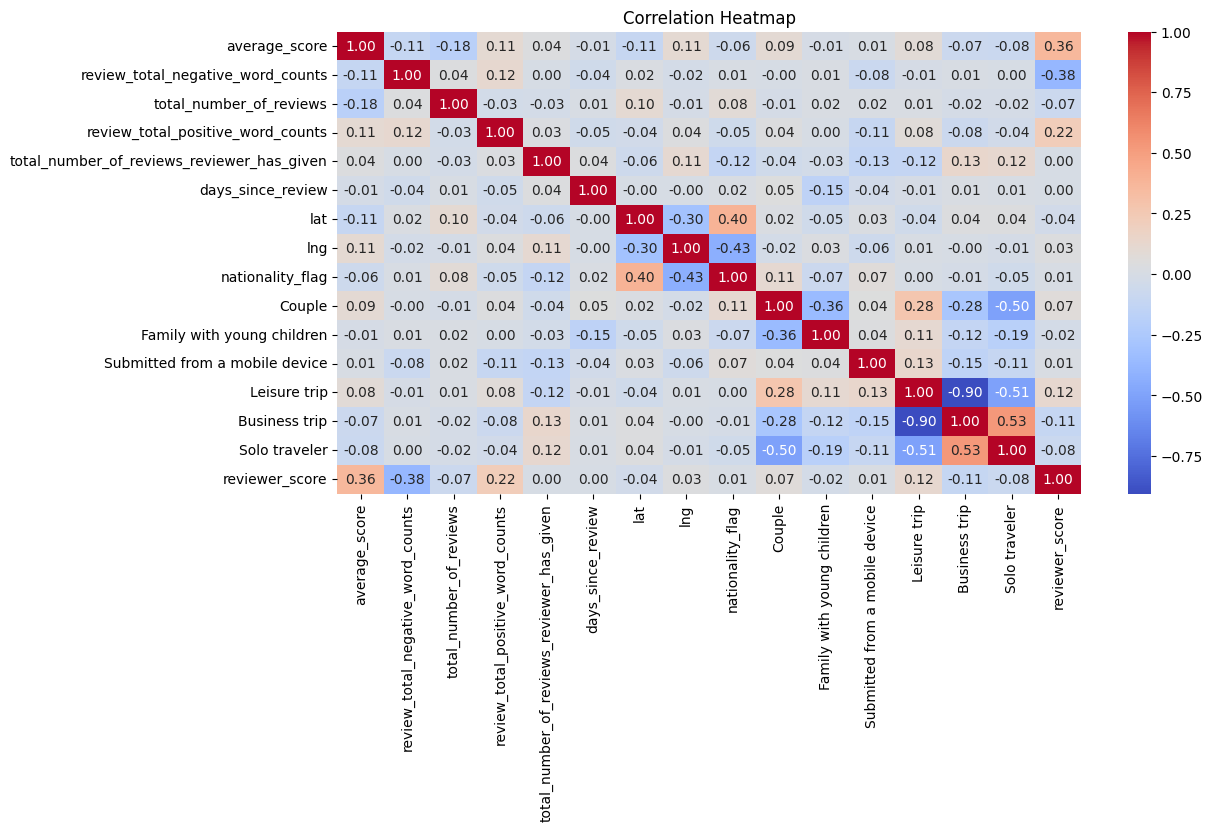

In [227]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show();

список потенциально бесполезных колонок:
 - total_number_of_reviews
 - total_number_of_reviews_reviewer_has_given
 - days_since_review
 - lat
 - lng
 - nationality_flag
 - Couple
 - Family with young children
 - Submitted from a mobile device
 - Solo traveler

In [232]:
# Для хиквадрат теста возьму категориальные и дискретные признаки
c = cat_f + ['average_score', 'lat', 'lng', 'nationality_flag',
 'Couple', 'Family with young children', 'Submitted from a mobile device',
 'Leisure trip', 'Business trip', 'Solo traveler']

<ipython-input-233-720e4b4f4d28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['country'] = label_encoder.fit_transform(df_corr['country'])
<ipython-input-233-720e4b4f4d28>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr[el] = df_corr[el].astype(int)


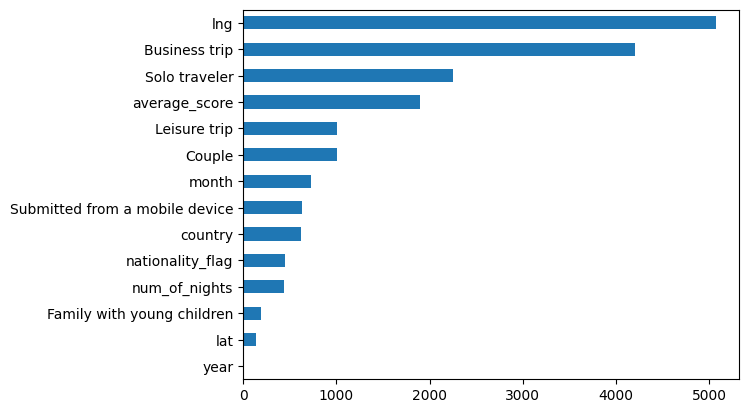

In [233]:
label_encoder = LabelEncoder()
df_corr['country'] = label_encoder.fit_transform(df_corr['country'])

for el in c:
  if el != 'country':
    df_corr[el] = df_corr[el].astype(int)
imp_cat = pd.Series(chi2(df_corr[c], y)[0], index=c)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

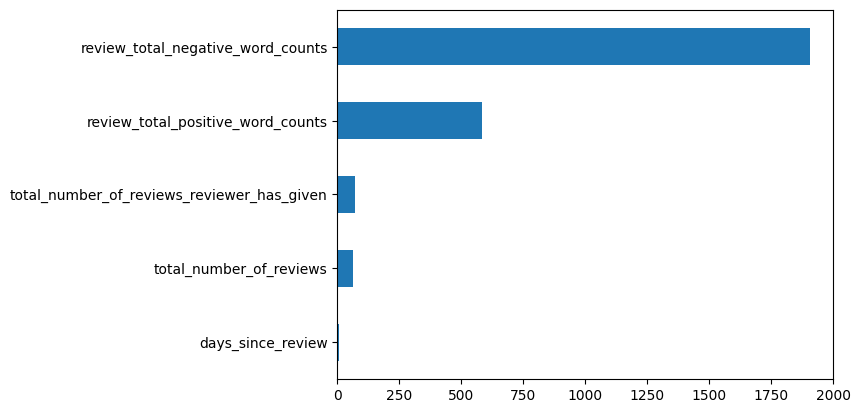

In [235]:
# Для анова теста использую числовые признаки которые не попали в категориальные
n = [num for num in num_columns if num not in c]

from sklearn.feature_selection import f_classif # anova
X = train[n]
y = train['reviewer_score']
imp_num = pd.Series(f_classif(X[n], y)[0], index = n)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

уберу те колонки которые оказались "бесполезными" в двух проверках на корреляцию

In [237]:
pierson_low_orr_columns = ['total_number_of_reviews_reviewer_has_given', 'days_since_review', 'lat', 'lng', 'nationality_flag', 'stays 3 nights', 'Couple', 'Stayed 2 nights',
                'Family with young children', 'Submitted from a mobile device', 'Stayed 1 nights', 'Solo traveler']

chi2_low_corr = ['year', 'lat', 'Family with young children']
anova_low_corr = ['days_since_review', 'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews']

column_list_for_drop = []
for el in pierson_low_orr_columns:
    if el in chi2_low_corr or el in anova_low_corr:
        column_list_for_drop.append(el)

In [238]:
column_list_for_drop

['total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'lat',
 'Family with young children']

In [239]:
for col in column_list_for_drop:
    train = train.drop(col, axis = 1)
    test = test.drop(col, axis = 1)

In [243]:
# Разделяю данные на 3 списка: категориальные, числовые и текст
cat_f = ['country', 'year', 'month', 'num_of_nights']
text = ['negative_review', 'positive_review']

# Пересоберу числовые фичи (так как некоторые колонки были удалены)
num_columns = []
for el in train.columns.tolist():
    if 'float' in str(train[el].dtypes) or 'int' in str(train[el].dtypes):
        num_columns.append(el)


num_columns.remove('reviewer_score')

In [244]:
X = train[num_columns + cat_f + text]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [256]:
catboost_model = CatBoostRegressor(iterations = 2000,
                          learning_rate = 0.3,
                          loss_function='RMSE',
                          verbose = 100,
                          eval_metric = 'MAPE',
                          random_seed = 886,
                          cat_features=cat_f,
                          text_features  = ['negative_review', 'positive_review'],
                          )
catboost_model.fit(X_train, y_train,  eval_set=(X_test, y_test), verbose=100)

0:	learn: 0.1747050	test: 0.1749034	best: 0.1749034 (0)	total: 2.33s	remaining: 1h 17m 28s
100:	learn: 0.1137915	test: 0.1148141	best: 0.1148141 (100)	total: 2m 53s	remaining: 54m 22s
200:	learn: 0.1100354	test: 0.1117837	best: 0.1117837 (200)	total: 5m 36s	remaining: 50m 7s
300:	learn: 0.1077058	test: 0.1102962	best: 0.1102934 (299)	total: 8m 23s	remaining: 47m 21s
400:	learn: 0.1060209	test: 0.1094080	best: 0.1094080 (400)	total: 11m 8s	remaining: 44m 25s
500:	learn: 0.1046421	test: 0.1088281	best: 0.1088281 (500)	total: 13m 48s	remaining: 41m 19s
600:	learn: 0.1034876	test: 0.1083526	best: 0.1083526 (600)	total: 16m 27s	remaining: 38m 19s
700:	learn: 0.1024843	test: 0.1080732	best: 0.1080732 (700)	total: 19m 6s	remaining: 35m 25s
800:	learn: 0.1015185	test: 0.1078620	best: 0.1078550 (799)	total: 21m 50s	remaining: 32m 40s
900:	learn: 0.1005878	test: 0.1076550	best: 0.1076549 (899)	total: 24m 33s	remaining: 29m 57s
1000:	learn: 0.0997740	test: 0.1074897	best: 0.1074887 (998)	total: 2

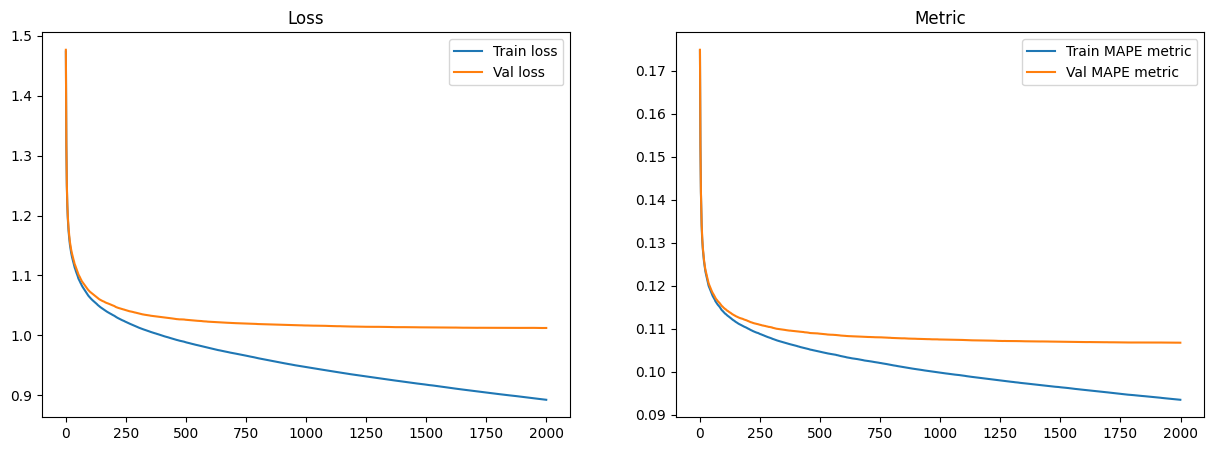

In [257]:
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.plot(catboost_model.evals_result_['learn']['RMSE'])
plt.plot(catboost_model.evals_result_['validation']['RMSE'])
plt.title('Loss')
plt.legend(['Train loss', 'Val loss'])
plt.subplot(122)
plt.plot(catboost_model.evals_result_['learn']['MAPE'])
plt.plot(catboost_model.evals_result_['validation']['MAPE'])
plt.title('Metric')
plt.legend(['Train MAPE metric', 'Val MAPE metric']);

In [269]:
y_pred = catboost_model.predict(X_test)
y_sub = catboost_model.predict(test[num_columns + cat_f + text])
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))
sub['reviewer_score'] = y_sub
sub.to_csv('/content/drive/MyDrive/my_submission_8.csv', header = True, index = False)

MAPE: 0.10674395235019428


In [275]:
y_sub = [round(el, 1) for el in catboost_model.predict(test[num_columns + cat_f + text])]
sub['reviewer_score'] = y_sub
sub.to_csv('/content/drive/MyDrive/my_submission_9.csv', header = True, index = False)

In [258]:
catboost_model.save_model('/content/drive/MyDrive/DSS/Catboost_regressor_model_031123.cbm',
           format="cbm",
           export_parameters=None,
           pool=None)

Случайный лес

In [262]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train[num_columns], y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test[num_columns])

In [264]:
y_pred = regr.predict(X_test[num_columns])
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13985407926717439


In [277]:
text

['negative_review', 'positive_review']

# ВЫВОДЫ:

Со случайным лесом не удалось добиться хороших результатов, по этому я использовала бустинг модель

я взяла кетбуст потому что он хорошо работает с категориями и хорошо обрабатывает текстовые фичи

Логично предположить что на оценку очень влияет то что написал человек в 'negative_review' и 'positive_review'

я пыталась извлечь часто встречающиеся слова из описаний и добавить их оне-хот енкодингом, для улучшения результата модели леса, но это не дало значимых результатов, по этому я почистила ноутбук от лишнего

Так же сделала небольшой сёрч по сидам, по этому выбрала наиболее удачный из проверенных, по этой причине в бустинг модели фиксиран другой сид, но в целом сильно большой разницы сид не дает. Ниже оставляю один из эекспериментов бустинг модели с сидом 42 (если важно оставить сид фиксированным)

In [ ]:
catboost_model = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.1,
                          loss_function='RMSE',
                          verbose = 100,
                          eval_metric = 'MAPE',
                          random_seed = 42,
                          cat_features=cat_f,
                          text_features  = ['negative_review', 'positive_review'],
                          )
catboost_model.fit(X_train, y_train,  eval_set=(X_test, y_test), verbose=100)

0:	learn: 0.1879787	test: 0.1879717	best: 0.1879717 (0)	total: 4.12s	remaining: 1h 8m 36s
100:	learn: 0.1209401	test: 0.1214779	best: 0.1214779 (100)	total: 2m 55s	remaining: 26m 5s
200:	learn: 0.1162003	test: 0.1169798	best: 0.1169798 (200)	total: 5m 36s	remaining: 22m 17s
300:	learn: 0.1137697	test: 0.1147917	best: 0.1147917 (300)	total: 8m 11s	remaining: 19m 2s
400:	learn: 0.1120889	test: 0.1133804	best: 0.1133804 (400)	total: 10m 51s	remaining: 16m 13s
500:	learn: 0.1108487	test: 0.1123854	best: 0.1123854 (500)	total: 13m 25s	remaining: 13m 21s
600:	learn: 0.1097561	test: 0.1115599	best: 0.1115599 (600)	total: 16m 4s	remaining: 10m 40s
700:	learn: 0.1088616	test: 0.1109550	best: 0.1109550 (700)	total: 19m 18s	remaining: 8m 14s
800:	learn: 0.1080617	test: 0.1104249	best: 0.1104249 (800)	total: 22m 14s	remaining: 5m 31s
900:	learn: 0.1073850	test: 0.1100173	best: 0.1100173 (900)	total: 24m 47s	remaining: 2m 43s
999:	learn: 0.1067684	test: 0.1096631	best: 0.1096631 (999)	total: 27m 17

In [ ]:
catboost_model.save_model('/content/drive/MyDrive/DSS/Catboost_regressor_model_301023.cbm',
           format="cbm",
           export_parameters=None,
           pool=None)

y_pred = catboost_model.predict(X_test)
y_sub = catboost_model.predict(test[num_columns + cat_f + text])
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))
sub['reviewer_score'] = y_sub
sub.to_csv('/content/drive/MyDrive/my_submission_4.csv', header = True, index = False)

MAPE: 0.10766135489751887
